In [1]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
import seaborn as seabornInstance 
import matplotlib.pyplot as plt  
from sklearn import metrics
import pandas as pd  
import numpy as np  
%matplotlib inline
import re
import os

In [2]:
df=pd.read_csv('covid19.csv')

In [3]:
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [4]:
df.columns=df.columns.str.lower()

In [5]:
df.rename(columns={'observationdate':'observation_date',
                   'province/state' :'state',
                   'country/region' :'country',
                   'last update'    :'last_update' },inplace=True)

In [6]:
def cleanCountry(country):
    country=re.sub(r'Mainland china','China',country)
    country=country.lower().strip()
    country=re.sub(r'[^a-z\s]+','',country)
    country=country.capitalize()
    return country

In [8]:
df.country=[cleanCountry(i) for i in df.country]

df.head()

,sno,observation_date,state,country,last_update,confirmed,deaths,recovered
0,1,01/22/2020,Anhui,China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,China,1/22/2020 17:00,0.0,0.0,0.0


In [9]:
country_meter=df.groupby(by=(['country','observation_date']))\
.agg({'confirmed':'sum','deaths':'sum','recovered':'sum'})\
.sort_values(by=['country','observation_date'], ascending=[True,True]).reset_index()

country_meter

,country,observation_date,confirmed,deaths,recovered
0,Afghanistan,02/24/2020,1.0,0.0,0.0
1,Afghanistan,02/25/2020,1.0,0.0,0.0
2,Afghanistan,02/26/2020,1.0,0.0,0.0
3,Afghanistan,02/27/2020,1.0,0.0,0.0
4,Afghanistan,02/28/2020,1.0,0.0,0.0
...,...,...,...,...,...
3223,Vietnam,03/15/2020,56.0,0.0,16.0
3224,Vietnam,03/16/2020,61.0,0.0,16.0
3225,Vietnam,03/17/2020,66.0,0.0,16.0
3226,Vietnam,03/18/2020,75.0,0.0,16.0


In [10]:
def forceMonInc(grp):
    if np.sum(np.diff(grp)<0)>0:
        return sorted(grp)
    else:
        return grp

In [11]:
monitor=country_meter.groupby(by=['country']).transform(lambda a: forceMonInc(a))

monitor

,confirmed,deaths,recovered
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
3223,56.0,0.0,16.0
3224,61.0,0.0,16.0
3225,66.0,0.0,16.0
3226,75.0,0.0,16.0


In [12]:
country_meter[monitor.columns]=monitor.values

country_meter

,country,observation_date,confirmed,deaths,recovered
0,Afghanistan,02/24/2020,1.0,0.0,0.0
1,Afghanistan,02/25/2020,1.0,0.0,0.0
2,Afghanistan,02/26/2020,1.0,0.0,0.0
3,Afghanistan,02/27/2020,1.0,0.0,0.0
4,Afghanistan,02/28/2020,1.0,0.0,0.0
...,...,...,...,...,...
3223,Vietnam,03/15/2020,56.0,0.0,16.0
3224,Vietnam,03/16/2020,61.0,0.0,16.0
3225,Vietnam,03/17/2020,66.0,0.0,16.0
3226,Vietnam,03/18/2020,75.0,0.0,16.0


In [13]:
data_scores=country_meter.groupby(['observation_date'])\
.agg({'confirmed':'sum','deaths':'sum','recovered':'sum'}).reset_index()

In [14]:
data_scores['observation_date']=pd.to_datetime(data_scores['observation_date'])

In [15]:
data_scores['since_day']=(data_scores['observation_date']-data_scores['observation_date'].min()).dt.days

In [16]:
data_scores.head(10)

,observation_date,confirmed,deaths,recovered,since_day
0,2020-01-22,554.0,17.0,28.0,0
1,2020-01-23,654.0,18.0,30.0,1
2,2020-01-24,941.0,26.0,36.0,2
3,2020-01-25,1438.0,42.0,39.0,3
4,2020-01-26,2118.0,56.0,52.0,4
5,2020-01-27,2927.0,82.0,61.0,5
6,2020-01-28,5578.0,131.0,107.0,6
7,2020-01-29,6165.0,133.0,126.0,7
8,2020-01-30,8235.0,171.0,143.0,8
9,2020-01-31,9925.0,213.0,222.0,9


In [17]:
X=data_scores['since_day'].values.reshape(-1,1)
y=data_scores['confirmed'].values.reshape(-1,1)

In [18]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=None)

In [19]:
model=LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [20]:
y_pred=model.predict(X_test)

In [21]:
df=pd.DataFrame({'Actual':y_test.flatten(),'Predicted':y_pred.flatten()})
df

,Actual,Predicted
0,42763.0,42829.076219
1,78599.0,79947.654529
2,941.0,-9755.576386
3,75138.0,67574.795092
4,2118.0,-3569.146668
5,40151.0,39735.861360
6,86004.0,101600.158543
7,19881.0,21176.572205
8,88362.0,104693.373402
9,5578.0,2617.283051


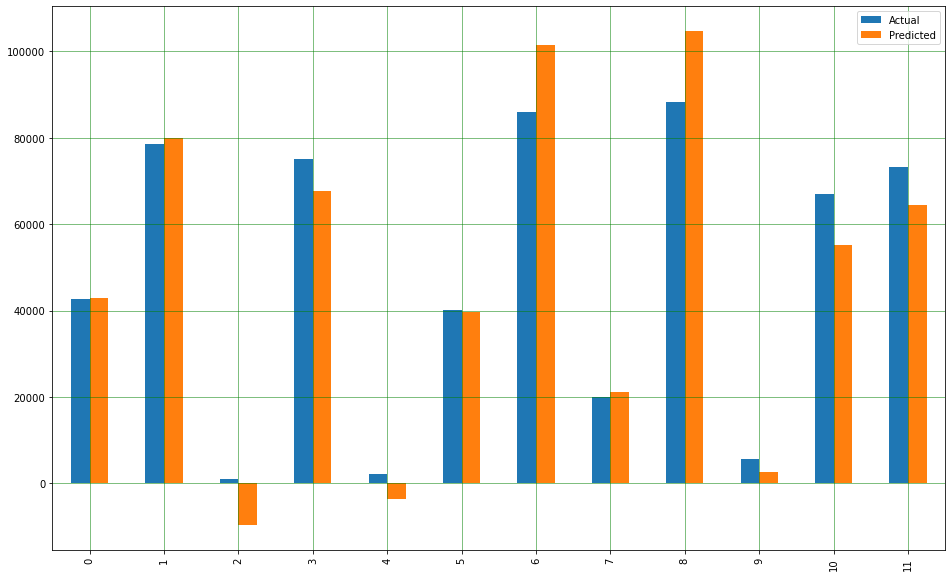

In [22]:
df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [23]:
n = X_test.shape[0]
p = X_test.shape[1]

In [24]:
r2 = metrics.r2_score(y_test, y_pred)
print('R^2:' , r2)

R^2: 0.9261907114759774


In [25]:
print('Adjusted R^2 :' , 1-(1-r2)*(n-1)/(n-p-1))

Adjusted R^2 : 0.9188097826235752


In [26]:
print('Mean Absolute Error:' , metrics.mean_absolute_error(y_test, y_pred))

Mean Absolute Error: 6869.841879967532


In [27]:
print('Mean Squared Error:' , metrics.mean_squared_error(y_test, y_pred))

Mean Squared Error: 78357088.17320637


In [28]:
print('Root Mean Squared Error:' , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Root Mean Squared Error: 8851.953918384708
